
<b><font size = 2><span style="font-family:'Times New Roman';color:#A8642A">🖼Image Captioning :  ViT + GPT2💬 </span></font></b>  

<b><font size = 2><span style="font-family:'Times New Roman';color:#A8642A;">Created By Burhanuddin Latsaheb </span></font> </b> 

# <center><font size = 8><span style="color:#422711;font-family:'Times New Roman'"> Image Captioning :  ViT + GPT2</span></font></center>


## <center><font size =4><span style="font-family:'Times New Roman';color:#F6923D"> If you find this notebook useful,support with an upvote👍👍 </span></font></center>


# <center><font size = 3><span style="color:#422711"> <p style="background-color:#422711;font-family:newtimeroman;color:#F6923D;font-size:200%;text-align:center;border-radius:100px 10px;">INTRODUCTION</p>   </span></font></center>
 
<font size = 5><span style="color:#A8642A;font-family:'Times New Roman'">Notebook Overview : </span></font>

* <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'"> This notebook contains:  </span></font>
    1. <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'">A Encoder Decoder Model which takes an image as an input and outputs a caption </span></font>
    2. <font size = 3><span style = "color:#3A3E59;font-family:'Times New Roman'">The Encoder used is <a href = "https://huggingface.co/google/vit-base-patch16-224"><b>Vision Transformer </b></a> </span></font>
    3. <font size =3><span style = "color:#3A3E59;font-family:'Times New Roman'">The Decoder used is <a href = "https://huggingface.co/gpt2"><b>GPT2</b></a></span></font>
    4. <font size =3><span style = "color:#3A3E59;font-family:'Times New Roman'"> The model is trained on <b>Flickr8k dataset</b></span></font>
    5. <font size =3><span style = "color:#3A3E59;font-family:'Times New Roman'"> The hugging face <a href = "https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Seq2SeqTrainer"><b>Seq2SeqTrainer</b></a> is used for finetuning the model</span></font>
   
*  <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'">The hugging face <b> transformers</b> library is used to finetune the model and <b> Pytorch</b> for data processing </span></font>


<p style="background-color:#422711;font-family:newtimeroman;color:#F6923D;font-size:110%;text-align:center;border-radius:200px 10px;">IMAGE CAPTIONING</p>
<br>

<font size = 3><span style = "color:#3A3E59;font-family:'Times New Roman'">Image Captioning is the task of describing the content of an image in words. This task lies at the intersection of computer vision and natural language processing. Most image captioning systems use an encoder-decoder framework, where an input image is encoded into an intermediate representation of the information in the image, and then decoded into a descriptive text sequence.</span></font>
<br>

<img src="https://raw.githubusercontent.com/danieljl/keras-image-captioning/master/results-without-errors.jpg">



<a id='top'></a>
<p style="background-color:#422711;font-family:newtimeroman;color:#F6923D;font-size:200%;text-align:center;border-radius:200px 10px;">TABLE OF CONTENTS</p>  

- [1. Imports](#1)
- [2. Hyperparameters](#2)
- [3. Helper Functions](#3)
- [4. Dataset](#4)
  * .[4.1 Feature Extractor and Tokenizer](#4.4)
  * [4.2 Transforms and dataframe](#4.1)
  * [4.3 Dataset Class](#4.2)
  * .[4.4 Train and validation dataset](#4.3)
- [5. Model Building](#5)
    * .[5.1 Model Initialization](#5.2)
- [6. Training](#6)
    * .[6.1 Training Arguments](#6.1)
    * .[6.2 Training using Seq2SeqTrainer](#6.2)
- .[7. Predictions](#7)

<a id="1"></a>
# <p style="background-color:#422711;font-family:newtimeroman;color:#F6923D;font-size:140%;text-align:center;border-radius:200px 10px;">1. IMPORTS 📂</p>
#### [Top ↑](#top)

In [17]:
import os

import datasets
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
import multiprocessing as mp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import io, transforms
from torch.utils.data import Dataset, DataLoader, random_split

from transformers import Seq2SeqTrainer ,Seq2SeqTrainingArguments
from transformers import VisionEncoderDecoderModel , BeitImageProcessor, AutoImageProcessor
from transformers import AutoTokenizer ,  GPT2Config , default_data_collator


if torch.cuda.is_available():    

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce MX130


<a id="2"></a>
# <p style="background-color:#422711;font-family:newtimeroman;color:#F6923D;font-size:140%;text-align:center;border-radius:200px 10px;">2. HYPERPARAMETERS</p>
#### [Top ↑](#top)

In [18]:
os.environ["WANDB_DISABLED"] = "true"
class config : 
    ENCODER = "microsoft/beit-base-patch16-224-pt22k-ft22k"
    DECODER = "gpt2"
    TRAIN_BATCH_SIZE = 2
    VAL_BATCH_SIZE = 2
    VAL_EPOCHS = 1
    LR = 5e-5
    SEED = 42
    MAX_LEN = 128
    SUMMARY_LEN = 20
    WEIGHT_DECAY = 0.01
    MEAN = (0.485, 0.456, 0.406)
    STD = (0.229, 0.224, 0.225)
    TRAIN_PCT = 0.95
    NUM_WORKERS = mp.cpu_count()
    EPOCHS = 3
    IMG_SIZE = (224,224)
    LABEL_MASK = -100
    TOP_K = 1000
    TOP_P = 0.95

<a id="3"></a>
# <p style="background-color:#422711;font-family:newtimeroman;color:#F6923D;font-size:140%;text-align:center;border-radius:200px 10px;">3. HELPER FUNCTIONS</p>
#### [Top ↑](#top)

<font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'"> There are Two helper functions:  </span></font>
1. <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'"> The first function is to <b>build special tokens</b> while tokenizing the captions  </span></font>
2. <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'">The second function is used to compute the <b>ROUGE-2</b> metrics as we are working with Transformers  </span></font>

In [19]:
def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
    outputs = [self.bos_token_id] + token_ids_0 + [self.eos_token_id]
    return outputs
AutoTokenizer.build_inputs_with_special_tokens = build_inputs_with_special_tokens

In [20]:
rouge = datasets.load_metric("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }


<a id="4"></a>
# <p style="background-color:#422711;font-family:newtimeroman;color:#F6923D;font-size:140%;text-align:center;border-radius:200px 10px;">4. DATASET</p>


<a id="4.4"></a>
## <font size = 5><span style="color:#A8642A;font-family:'Times New Roman'">4.1 Feature Extractor and Tokenizer : </span></font>
#### [Top ↑](#top)

1. <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'"> The Feature extractor is loaded using <b>ViTFeatureExtractor</b>  </span></font>
2. <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'">The tokenizer for GPT2 is loaded using the <b>AutoTokenizer</b>  </span></font>

In [21]:
feature_extractor = BeitImageProcessor.from_pretrained(config.ENCODER)
tokenizer = AutoTokenizer.from_pretrained(config.DECODER)
tokenizer.pad_token = tokenizer.unk_token

<a id="4.1"></a>
## <font size = 5><span style="color:#A8642A;font-family:'Times New Roman'">4.2 Transforms and dataframe : </span></font>
#### [Top ↑](#top)

 <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'">The Transformations used are </span></font>
> 1. <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'"><b>Resizing</b> the image to (224,224) </span></font>
2. <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'"><b>Normalizing</b> the image</span></font>
3. <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'"> Converting the image to <b>Tensor</b>  </span></font>

In [22]:
transforms_img = transforms.Compose(
    [
        transforms.Resize(config.IMG_SIZE), 
        transforms.ToTensor(),
        transforms.Normalize(
            mean=0.5, 
            std=0.5
        )
   ]
)
df=  pd.read_csv("./data/flickr8k/captions.txt")
train_df , val_df = train_test_split(df , test_size = 0.2)
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


<a id="4.2"></a>
## <font size = 5><span style="color:#A8642A;font-family:'Times New Roman'">4.3 Dataset Class : </span></font>
#### [Top ↑](#top)

<font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'">The dataset is created using the following steps </span></font>
> 1. <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'">We read the image using the <b>Image</b> function of PIL library </span></font>
2. <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'"> The image is <b>transformed</b> using the transformed defined above</span></font>
3. <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'">The transformed image is passed through the <b>feature extractor</b> to extract the pixel values from the image </span></font>
4. <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'"> The captions are loaded from the dataframe</span></font>
5. <font size = 3><span style = "color:#3A3E59;font-family:'Times New Roman'">The captions are <b>tokenized</b></span></font>
6. <font size = 3><span style = "color:#3A3E59;font-family:'Times New Roman'">The tokenized captions are <b>padded</b> to max length</span></font>
7. <font size = 3><span style = "color:#3A3E59;font-family:'Times New Roman'">The images and tokenized captions are returned</span></font>

In [23]:
class ImgDataset(Dataset):
    def __init__(self, df,root_dir,tokenizer,feature_extractor, transform = None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        self.tokenizer= tokenizer
        self.feature_extractor = feature_extractor
        self.max_length = 50
    def __len__(self,):
        return len(self.df)
    def __getitem__(self,idx):
        caption = self.df.caption.iloc[idx]
        image = self.df.image.iloc[idx]
        img_path = os.path.join(self.root_dir , image)
        img = Image.open(img_path).convert("RGB")
        
        # if self.transform is not None:
        #     img= self.transform(img)
        pixel_values = self.feature_extractor(img, return_tensors="pt").pixel_values
        captions = self.tokenizer(caption,
                                 padding='max_length',
                                 max_length=self.max_length).input_ids
        captions = [caption if caption != self.tokenizer.pad_token_id else -100 for caption in captions]
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(captions)}
        return encoding
        
        

<a id="4.3"></a>
## <font size = 5><span style="color:#A8642A;font-family:'Times New Roman'">4.4 Train and validation dataset: </span></font>
#### [Top ↑](#top)

In [24]:
train_dataset = ImgDataset(train_df, root_dir = "./data/flickr8k/Images",tokenizer=tokenizer,feature_extractor = feature_extractor, transform=transforms_img)
val_dataset = ImgDataset(val_df , root_dir = "./data/flickr8k/Images",tokenizer=tokenizer,feature_extractor = feature_extractor, transform=transforms_img) 

<a id="5"></a>
# <p style="background-color:#422711;font-family:newtimeroman;color:#F6923D;font-size:140%;text-align:center;border-radius:200px 10px;">5. MODEL BUILDING</p>

<p style="background-color:#422711;font-family:newtimeroman;color:#F6923D;font-size:100%;text-align:center;border-radius:200px 10px;">ENCODER</p>
<br>

<img src = "https://production-media.paperswithcode.com/methods/Screen_Shot_2021-01-26_at_9.43.31_PM_uI4jjMq.png">

<br>
<font size = 3><span style = "color:#3A3E59;font-family:'Times New Roman'">The Vision Transformer, or ViT, is a model for image classification that employs a Transformer-like architecture over patches of the image. An image is split into fixed-size patches, each of them are then linearly embedded, position embeddings are added, and the resulting sequence of vectors is fed to a standard Transformer encoder. In order to perform classification, the standard approach of adding an extra learnable “classification token” to the sequence is used.</span></font>

<p style="background-color:#422711;font-family:newtimeroman;color:#F6923D;font-size:100%;text-align:center;border-radius:200px 10px;">DECODER</p>
<br> 

<img src = "https://i.stack.imgur.com/7J4O7.png" >

<br>

<font size = 3><span style = "color:#3A3E59;font-family:'Times New Roman'">GPT-2 is a transformers model pretrained on a very large corpus of English data in a self-supervised fashion. inputs are sequences of continuous text of a certain length and the targets are the same sequence, shifted one token (word or piece of word) to the right. The model uses internally a mask-mechanism to make sure the predictions for the token i only uses the inputs from 1 to i but not the future tokens.</span></font>
    
<font size = 3><span style = "color:#3A3E59;font-family:'Times New Roman'">This way, the model learns an inner representation of the English language that can then be used to extract features useful for downstream tasks. The model is best at what it was pretrained for however, which is generating texts from a prompt.</span></font>
    

<a id="5.1"></a>
## <font size = 5><span style="color:#A8642A;font-family:'Times New Roman'">5.1 Model Initialization : </span></font>
#### [Top ↑](#top)

In [25]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(config.ENCODER, config.DECODER)

Some weights of the model checkpoint at microsoft/beit-base-patch16-224-pt22k-ft22k were not used when initializing BeitModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BeitModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BeitModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size
# set beam search parameters
model.config.eos_token_id = tokenizer.sep_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.max_length = 128
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

<a id="6"></a>
# <p style="background-color:#422711;font-family:newtimeroman;color:#F6923D;font-size:140%;text-align:center;border-radius:200px 10px;">6. TRAINING</p>

<a id="6.1"></a>
### <font size = 5><span style="color:#A8642A;font-family:'Times New Roman'">6.1 Training Arguments : </span></font>
#### [Top ↑](#top)

In [27]:
training_args = Seq2SeqTrainingArguments(
    output_dir='VIT_large_gpt2',
    per_device_train_batch_size=config.TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=config.VAL_BATCH_SIZE,
    predict_with_generate=True,
    evaluation_strategy="epoch",
    do_train=True,
    do_eval=True,
    logging_steps=1024,  
    save_steps=2048, 
    warmup_steps=1024,  
    learning_rate = 5e-5,
    #max_steps=1500, # delete for full training
    num_train_epochs = config.EPOCHS, #TRAIN_EPOCHS
    overwrite_output_dir=True,
    save_total_limit=1,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


<a id="6.2"></a>
### <font size = 5><span style="color:#A8642A;font-family:'Times New Roman'">6.2 Training using Seq2SeqTrainer : </span></font>
#### [Top ↑](#top)

In [28]:
# instantiate trainer
trainer = Seq2SeqTrainer(
    tokenizer=feature_extractor,
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=default_data_collator,
)
trainer.train()

/home/mohit/mambaforge/envs/DL/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/48546 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 3.95 GiB total capacity; 3.00 GiB already allocated; 17.94 MiB free; 3.29 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
trainer.save_model('VIT_large_gpt2')

Saving model checkpoint to VIT_large_gpt2
Configuration saved in VIT_large_gpt2/config.json
Model weights saved in VIT_large_gpt2/pytorch_model.bin
Feature extractor saved in VIT_large_gpt2/preprocessor_config.json


<a id="7"></a>
# <p style="background-color:#422711;font-family:newtimeroman;color:#F6923D;font-size:140%;text-align:center;border-radius:200px 10px;">7. PREDICTIONS</p>
#### [Top ↑](#top)

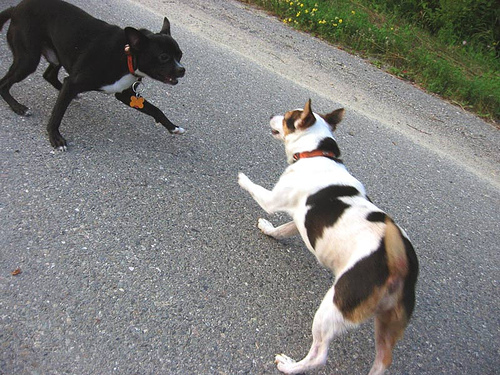

In [ ]:
img =  Image.open("/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg").convert("RGB")
img

In [ ]:
generated_caption = tokenizer.decode(model.generate(feature_extractor(img, return_tensors="pt").pixel_values.to("cuda"))[0])
print('\033[96m' +generated_caption[:85]+ '\033[0m')

<|endoftext|>A black dog and a white dog are running on the street. The black dog is 


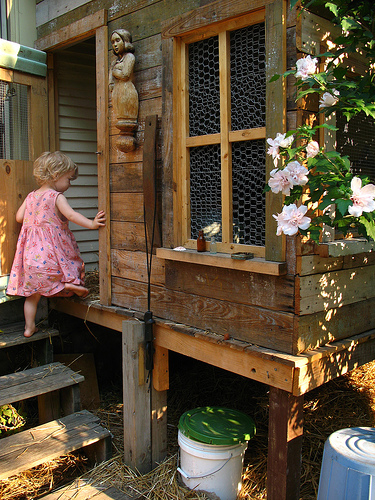

In [ ]:
img =  Image.open("/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg").convert("RGB")
img

In [ ]:
generated_caption = tokenizer.decode(model.generate(feature_extractor(img, return_tensors="pt").pixel_values.to("cuda"))[0])
print('\033[96m' +generated_caption[:120]+ '\033[0m')

<|endoftext|>A little girl in a pink dress is standing in front of a wooden house. She is looking at a wooden staircase.


# <center><font size = 3><span style="color:#F6923D"><b> Thank You for reading 😊<br>If you have any suggestions or feeback, please let me know</b></span></font></center>
#### [Top ↑](#top)